### References:
Topological Sorting: https://en.wikipedia.org/wiki/Topological_sorting

Dynamic Programming: https://en.wikipedia.org/wiki/Dynamic_programming

In [227]:
import random

In [228]:
class Task:
    def __init__(self, name, operation_time, predecessors=None, topological_order=None, start_time = None):
        """
        Initialize a Task instance.

        :param name: Unique identifier for the task.
        :param operation_time: Time taken to complete the task (int or float).
        :param predecessors: List of Task objects that must be completed before this task.
        :param topological_order: Integer representing the task's topological order in the workflow.
        """
        self.name = name
        self.operation_time = operation_time
        self.predecessors = predecessors if predecessors is not None else []
        self.topological_order = topological_order
        self.start_time = 0
        self.end_time = operation_time
        self.kahn_predecessors = predecessors if predecessors is not None else []

    def add_predecessor(self, task):
        """
        Add a predecessor to the current task.

        :param task: Task object that should be a predecessor.
        """
        self.predecessors.append(task)
        self.kahn_predecessors.append(task)
    
    def remove_kahn_predecessor(self, task):
        """
        Remove a predecessor from the current task (based on Kahn's Algorithm).

        :param task: Task object to be removed from the predecessors list.
        """
        if task in self.kahn_predecessors:
            self.kahn_predecessors.remove(task)
        else:
            print(f"Task {task.name} is not a predecessor of {self.name}.")     

    def get_predecessor_names(self):
        """
        Get the names of the predecessors.

        :return: List of names of predecessor tasks.
        """
        return [task.name for task in self.predecessors]

    def set_topological_order(self, order):
        """
        Set the topological order for the task.

        :param order: Integer value representing the task's order in the workflow.
        """
        self.topological_order = order

    def get_topological_order(self):
        """
        Get the topological order of the task.

        :return: Integer representing the task's topological order, or None if not set.
        """
        return self.topological_order
    
    def set_start_time(self, time):
        """
        Set the start time of the task.

        :param order: Integer value representing the task start time of execution.
        """
        self.start_time = time
        self.end_time = self.start_time + self.operation_time

    def __repr__(self):
        """
        Representation of the Task object for debugging purposes.

        :return: String representation of the task.
        """
        return (f"Task(name={self.name}, operation_time={self.operation_time}, "
                f"predecessors={self.get_predecessor_names()}, topological_order={self.topological_order}, "
                f"start_time={self.start_time}, end_time={self.end_time} ")


In [229]:
class TaskManager:
    def __init__(self):
        """
        Initialize a TaskManager instance to hold and manage tasks.
        """
        self.tasks = []

    def add_task(self, task):
        """
        Add a task to the task manager.

        :param task: Task object to be added.
        """
        self.tasks.append(task)


    def order_tasks_topologicaly(self):
        """
        Return tasks ordered by their topological order.

        :return: List of Task objects sorted by topological order.
        """
        # Ensure all tasks have a topological order set
        self.tasks = sorted(self.tasks, key=lambda task: task.get_topological_order())
    
    def check_topological_order_validity(self):
        """
        Check if the current topological order respects the predecessor constraints.

        :return: True if valid, False otherwise.
        """
        for task in self.tasks:
            for predecessor in task.predecessors:
                # If any predecessor has a topological order greater than or equal to the task's order, it's invalid
                if predecessor.get_topological_order() > task.get_topological_order():
                    return False
        return True
    
    def check_predecessor_completion_validity(self):
        """
        Check if the predecessors task are completed before tasks start time.

        :return: True if valid, False otherwise.
        """
        for task in self.tasks:
            for predecessor in task.predecessors:
                # If any predecessor has a topological order greater than or equal to the task's order, it's invalid
                if predecessor.end_time > task.start_time:
                    return False
        return True
    
    def check_processor_constraint_validity(self, p):
        """
        Check if  p processor constraint is respected.

        :return: True if valid, False otherwise.
        """
        solution_value = self.solution_value()

        for i in range(solution_value):
            if p < sum(task.start_time <= i < task.end_time for task in self.tasks):
                return False
        return True

    
    def solution(self):
        """
        Returns current solution based on start time.

        :return: List of tuples (name, start_time)
        """
        return [(task.name, task.start_time) for task in self.tasks]
    
    def solution_value(self):
        """
        Returns total time of excution of solution.

        :return: value (int)
        """
        return max(task.end_time for task in self.tasks)
    
    
                
    def kahn_alogrithm(self):
        """
        Updates topological order based on kahn algorithm.

        """
                
        L = list() # Empty list that will contain the sorted elements
        S = set(task for task in self.tasks if len(task.kahn_predecessors) == 0) # Set of all nodes with no predecessors

        R = set(task for task in self.tasks) - S # Set of all nodes with predecessors
        
      
        while len(S) != 0:
            removed_task = S.pop()
            L.append(removed_task)
            for task in R:
                if removed_task in task.kahn_predecessors:
                    task.remove_kahn_predecessor(removed_task)
                    if len(task.kahn_predecessors)== 0:
                        S.add(task)    
            R = R-S

        # Reset kahn predecessors
        for task in self.tasks:
            task.kahn_predecessors = list(task.predecessors)
        
        if len(L) != len(self.tasks):
            print('Graph has at least on cycle')

        else:
            for index, task in enumerate(L):
                task.set_topological_order(index + 1)
        

    def longest_path(self):
        """
        Finds the longest path in the network using dynamic programming.

        :return: Length of the path (int, float)
        """
        
        self.kahn_alogrithm() 
        self.order_tasks_topologicaly() # Order tasks topologically based on kahn algorithm results

        for task in self.tasks:
            list_of_predecessors_end_time = [predecessor.end_time for predecessor in task.predecessors] + [0]
            max_start_time = max(list_of_predecessors_end_time)            
            task.set_start_time(max_start_time)

        longest_path = max(task.end_time for task in self.tasks)

        return longest_path
        

    def parallel(self, p):
        """
        Finds a parallel solution for processing all tasks.

        :return: Solution
        """

        for task in self.tasks:
            task.start_time = 0
            
        processors = {f'processor_{i}': 0 for i in range(1,p+1)} # Next available time

        for task in self.tasks:

            next_processor_available = min(processors, key=processors.get) 
            next_processor_time_available = processors[next_processor_available]
            
            topological_time_available = max([predecessor.end_time for predecessor in task.predecessors] + [0])

            start_time = max(next_processor_time_available, topological_time_available)

            processors[next_processor_available] = start_time + task.operation_time
            task.set_start_time(start_time) 


    def swap_adjacent_tasks(self, position_right, voisinage = 1):
        position_left = max(position_right - voisinage,0)
        topo_order_right = self.tasks[position_right].get_topological_order()
        topo_order_left = self.tasks[position_left].get_topological_order()
        self.tasks[position_right].set_topological_order(topo_order_left)
        self.tasks[position_left].set_topological_order(topo_order_right)


    def vns(self, perturbation_pct, p):
        best_solution_value = self.solution_value()
        best_topo = {task.name: task.get_topological_order() for task in self.tasks}
        lower_bound = self.longest_path()

        if best_solution_value == lower_bound:
            print('Already Optimal')
            self.parallel(p=p)
            return # Converge

        for voisinage in [1,2]:
            print('Voisinage: ', voisinage)
            solution_improved = True

            while solution_improved:
                solution_improved = False
                
                for i in range(1, len(self.tasks)):
                    print(' Itération: ', i)
                    self.parallel(p=p)
                    current_solution_value = self.solution_value()
                    # print('current solution: ', [(task.name, task.start_time, task.get_topological_order()) for task in self.tasks])

                    self.swap_adjacent_tasks(position_right=i, voisinage=voisinage)
                    self.order_tasks_topologicaly()
                    # print('Try: ', self.solution())

                    if self.check_topological_order_validity():
                        self.parallel(p=p)
                        new_solution_value = self.solution_value()
                        print('     Valid solution')

                        if new_solution_value < current_solution_value:
                            if new_solution_value < best_solution_value:
                                best_solution_value = new_solution_value
                                best_topo = {task.name: task.get_topological_order() for task in self.tasks}
                                solution_improved = True
                                print('         Amélioration', new_solution_value)

                                if best_solution_value == lower_bound:
                                    print('         Optimal Solution Found')
                                    return #Converge
                            
                        else:
                            if perturbation_pct > random.random():
                                print('         Perturbation')
                            else:
                                self.swap_adjacent_tasks(position_right=i, voisinage=voisinage)
                                self.order_tasks_topologicaly()
                                print('         Non ameliorant')
                        
                    else:
                        self.swap_adjacent_tasks(position_right=i, voisinage=voisinage)
                        self.order_tasks_topologicaly()
                        print('     Non valid')

        for task in self.tasks:
            task.set_topological_order(best_topo[task.name])
        self.order_tasks_topologicaly()
        self.parallel(p=p)

      

    def __repr__(self):
        """
        Representation of the TaskManager object for debugging purposes.

        :return: String representation of all tasks in topological order.
        """
        return f"Tasks: {self.tasks}"


In [230]:
# Inititialization des taches, duréee et prédécesseurs
A = Task('A', 3)
B = Task('B', 3)
C = Task('C', 2)
D = Task('D', 2)
E = Task('E', 3)
F = Task('F', 5)


B.add_predecessor(A)
C.add_predecessor(A)
D.add_predecessor(A)
E.add_predecessor(C)
E.add_predecessor(D)
F.add_predecessor(E)
F.add_predecessor(B)
F.add_predecessor(D)


In [231]:
# Initialization d'un gestionnaire de tâche
task_manager = TaskManager()
task_manager.add_task(A)
task_manager.add_task(B)
task_manager.add_task(C)
task_manager.add_task(D)
task_manager.add_task(E)
task_manager.add_task(F)

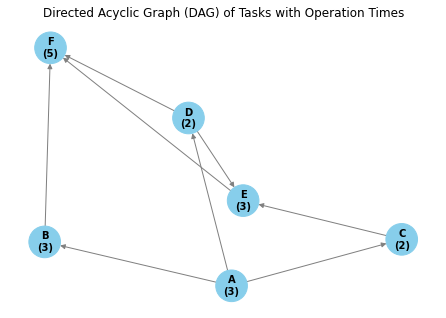

In [232]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges from tasks' predecessors to the tasks themselves
for task in task_manager.tasks:
    for predecessor in task.predecessors:
        G.add_edge(predecessor.name, task.name)

# Define operation times as labels
operation_times = {task.name: f"{task.operation_time}" for task in task_manager.tasks}

# Set node positions using spring layout
pos = nx.spring_layout(G)

# Set node sizes and other visual parameters
node_sizes = [1000 for _ in G.nodes()]  # Size of the nodes
edge_color = "gray"  # Color of the edges
node_color = "skyblue"  # Color of the nodes
font_size = 10  # Font size for labels

# Set the labels with operation times
task_labels = {node: f"{node}\n({operation_times[node]})" for node in G.nodes()}

# Adjust the figure size to a smaller one (e.g., 6x4 inches)
plt.figure(figsize=(6, 4))  # Smaller figure size

# Draw the graph with labels including operation times
nx.draw(G, pos, with_labels=True, labels=task_labels, node_size=node_sizes, 
        node_color=node_color, font_size=font_size, font_weight="bold", 
        edge_color=edge_color, arrows=True)

# Set the title of the graph
plt.title("Directed Acyclic Graph (DAG) of Tasks with Operation Times")

# Show the plot
plt.show()


In [233]:
p = 2 # Number of processors available
lower_bound = task_manager.longest_path()
task_manager.kahn_alogrithm()
task_manager.order_tasks_topologicaly()
task_manager.parallel(p=p)
solution = task_manager.solution()
value = task_manager.solution_value()

print(f'Solution: {solution}')
print(f'Value: {value}')
print(f'Lower bound: {lower_bound}')

Solution: [('A', 0), ('C', 3), ('B', 3), ('D', 5), ('E', 7), ('F', 10)]
Value: 15
Lower bound: 13


[('A', 0), ('D', 3), ('C', 3), ('B', 5), ('E', 5), ('F', 8)]

In [234]:
#Greedy
task_manager.vns(perturbation_pct=0, p=p)

print('Solution Value: ', task_manager.solution_value())
print('Solution: ', task_manager.solution())

print(task_manager.check_predecessor_completion_validity())
print(task_manager.check_topological_order_validity())
print(task_manager.check_processor_constraint_validity(p=p))

Voisinage:  1
 Itération:  1
     Non valid
 Itération:  2
     Valid solution
         Non ameliorant
 Itération:  3
     Valid solution
         Amélioration 13
         Optimal Solution Found
Solution Value:  13
Solution:  [('A', 0), ('C', 3), ('D', 3), ('B', 5), ('E', 5), ('F', 8)]
True
True
True


In [235]:
task_manager.tasks

[Task(name=A, operation_time=3, predecessors=[], topological_order=1, start_time=0, end_time=3 ,
 Task(name=C, operation_time=2, predecessors=['A'], topological_order=2, start_time=3, end_time=5 ,
 Task(name=D, operation_time=2, predecessors=['A'], topological_order=3, start_time=3, end_time=5 ,
 Task(name=B, operation_time=3, predecessors=['A'], topological_order=4, start_time=5, end_time=8 ,
 Task(name=E, operation_time=3, predecessors=['C', 'D'], topological_order=5, start_time=5, end_time=8 ,
 Task(name=F, operation_time=5, predecessors=['E', 'B', 'D'], topological_order=6, start_time=8, end_time=13 ]